## Tomato leaf disease detection 
* The following are disorders of Tomato Leaves
    1. Alternaria Canker
    2. Bacterial Canker
    3. Bacterial Speck
    4. Bacterial Spot
    5. Early Blight
    6. Gray Leaf Spot
    7. Late Blight
    8. Leaf Mold and etc.
* In this project, I'm going to use 10 classes of tomato leaf diseases
* Importing the neccessary `packages`


In [34]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras import models, layers
import os

### Defining golobal variables

In [35]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 16
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

### Loading the image data
* Next I am going to generate a **`tf.data.Dataset`** from image files in a directory.
* **tf.data.Dataset** yields batches of images from the subdirectories

In [36]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                "Tomato_disease_dataset",
                                                 shuffle = True,
                                                image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                batch_size = BATCH_SIZE)

Found 6814 files belonging to 5 classes.


In [37]:
class_names = image_dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

## Visualizing the data points
* Data visualization tools and technologies are essential to analyzing massive amounts of information and making data-driven decisions.
* Visualizing the data will help us to see the structure of the data we are working with and even it help us to check whther we are going in the right way or not...
* And, this is very important thing I have learned from https://www.youtube.com/watch?v=tpCFfeUEGs8&ab_channel=DanielBourke
## `Machine learning explorer's Motto`...Visualize, Visualize, Visualize....

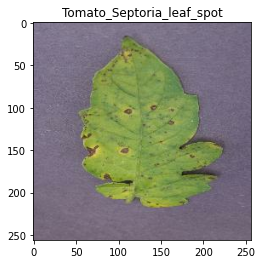

In [38]:
#.take(1) is a fucntion that returns a tuple of (data, label) 
for imag_batch, label_batch in image_dataset.take(1):
    plt.imshow(imag_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

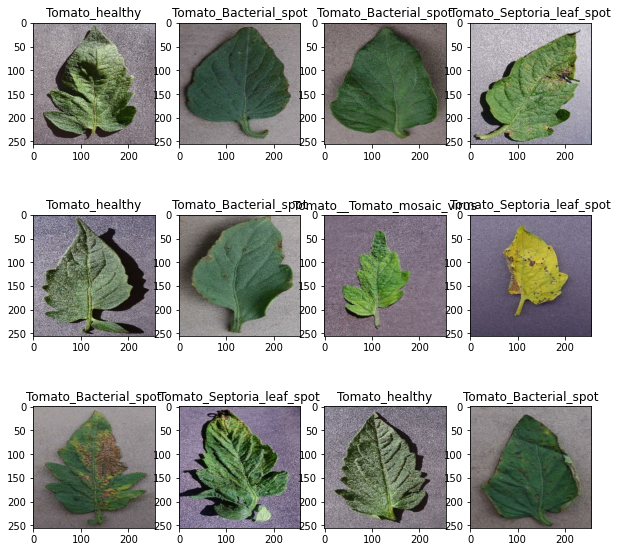

In [39]:
for image_data, image_label in image_dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_data[i].numpy().astype("uint8"))
        plt.title(class_names[image_label[i]])

In [3]:
0.1*419

41.900000000000006

In [13]:
#Our data is compiled as batch of 32
#that means the length of ourdata is 68
#Therefore we are going to take the first 54 batch of the data as our trainning data
# 54 = 0.8*68...80% of 68
train_data = image_dataset.take(335)

# the following line of code is telling us that we are going to skip the first
#54 batchs of our data and take the remaining data
test_validation_data = image_dataset.skip(335)

#The next step is to split this validation_test_data into testing and validation data
validation_data = test_validation_data.take(41)
#The test data set is the remaining of the data
test_data = test_validation_data.skip(41)

In [14]:
len(train_data), len(test_validation_data), len(validation_data), len(test_data)

(335, 91, 41, 50)

## Splitting the data
* The reason is that when the dataset is split into train and test sets, **there will not be enough data in the training dataset for the model to learn an effective mapping of inputs to outputs**.
* There will also not be enough data in the test set to effectively evaluate the model performance.
* Now, I am going to split the data into training, validation and testing data
* 80% of the data is for training, 10% for validating and the remaining 10% is for testing purpose

In [40]:
def train_validation_test_split(dataset,
                                train_data_size = 0.8,
                               validation_data_size = 0.1,
                               test_data_size = 0.1,
                               shuffle = True,
                               shuffle_size = 10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 12)
    #we need take only the integer values of the data
    size_of_train_data = int(train_data_size*dataset_size)
    size_of_vaidation_data = int(validation_data_size*dataset_size)
    
    #take the first 8 batchs
    train_dataset = dataset.take(size_of_train_data)
    
    #skip the first 54 batchs and take the next 6 batchs for validation
    validation_dataset = dataset.skip(size_of_train_data).take(size_of_vaidation_data)
    #skipt all of the taken data and return the remaining 8 batchs
    test_dataset = dataset.skip(size_of_train_data).skip(size_of_vaidation_data)
    
    return train_dataset, validation_dataset, test_dataset

In [41]:
train_data, validation_data, test_data = train_validation_test_split(image_dataset)
len(train_data),len(validation_data), len(test_data)

(340, 42, 44)

## Catching and prefetching of the data
* **Cache prefetching** is a technique used by **computer processors to boost execution performance** by fetching instructions or data from their **original storage in slower memory to a faster local memory** before it is actually needed
* Watch the following video for details...
https://www.youtube.com/watch?v=MLEKEplgCas&ab_channel=codebasics

In [42]:
#AUTOTUNE in the following line of code means leaving everything to tensorflow...to decide batch size, when to load...  
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
validation_data = validation_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

## Resizing and Rescaling of the image
*  **`tf.keras.layers.experimental.preprocessing.Resizing`** resizes an image input to a target height and width 

In [43]:
#Resizing and rescaling the image
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    #Neural networks play with nothing other than numbers, so we have to normalize the image data in the rang [0, 255]
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Model Creation
* Model creation is not a simple task, it is all about try and error
* The model I am going to create is composed of the following steps
    1. Convolution
    2. Max pooling
    3. Convolution
    4. Max pooling
    5. Convolution
    6. Max pooling
    7. Convolution
    8. Max pooling
    9. Convolution
    10. Max pooling
    11. Convolution
* Finaly before loading the data into the neural network, we have to flatten the data
* I am not going to the terms **Convolution**, **Max pooling**, kernel, filter and etc and for further understanding watch the following tutorials
1. https://www.youtube.com/watch?v=zfiSAzpy9NM&ab_channel=codebasics
2. https://www.youtube.com/watch?v=FmpDIaiMIeA&ab_channel=BrandonRohrer
3. https://www.youtube.com/watch?v=2-Ol7ZB0MmU&ab_channel=Serrano.Academy

In [80]:
toamato_disease_detector_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    #optional usage...activation=tf.keras.activations.relu
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])
toamato_disease_detector_model.build(input_shape = INPUT_SHAPE)

### Highlights about the created model...
*  What does ` layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE)` mean... convolution layer with 32 filters and `kernel size` of (3X3)..Image and activation fucntion of `ReLU`-rectified linear unit...
*  `MaxPooling`-goes around window size of (2X2) and takes maximum of the four elements and create another image...
*  Unlike for the hidden layers, we use softmax as activationn function for the output layer...
*  Even though I listed about 10 classes at the outset of this project, My Machine is incapable of processing that much data and I reduced number of classes to only five, and I loaded the images in batches of 16.
* I will describe `ReLU` and `sfotmax` using simple example

## Example to describe `ReLU` and `softmax`

In [90]:
raw_data = tf.cast(tf.range(-15, 15), tf.float32)
raw_data

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,
        -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.], dtype=float32)>

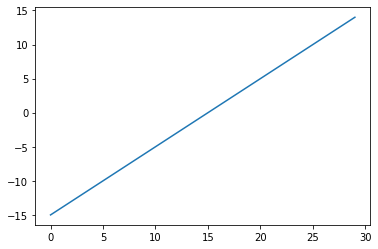

In [91]:
plt.plot(raw_data)

## The `sigmoid()` function
* For details...
https://www.youtube.com/watch?v=icZItWxw7AI&ab_channel=codebasics

In [92]:
def sigmoid(x):
    """
    sigmoid(x) = 1/(1+exp(-x))
    """
    return 1 / (1 + tf.exp(-x))

In [93]:
sigmoid(raw_data)

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([3.0590220e-07, 8.3152804e-07, 2.2603244e-06, 6.1441751e-06,
       1.6701422e-05, 4.5397872e-05, 1.2339458e-04, 3.3535014e-04,
       9.1105117e-04, 2.4726233e-03, 6.6928510e-03, 1.7986210e-02,
       4.7425874e-02, 1.1920292e-01, 2.6894143e-01, 5.0000000e-01,
       7.3105860e-01, 8.8079703e-01, 9.5257413e-01, 9.8201376e-01,
       9.9330717e-01, 9.9752742e-01, 9.9908900e-01, 9.9966466e-01,
       9.9987662e-01, 9.9995458e-01, 9.9998331e-01, 9.9999380e-01,
       9.9999774e-01, 9.9999917e-01], dtype=float32)>

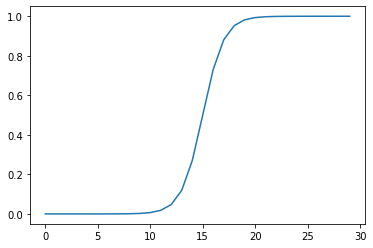

In [95]:
plt.plot(sigmoid(raw_data))

## The `ReLU` function

In [97]:
def relu(x):
    return tf.maximum(0,x)

In [99]:
relu(raw_data)

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14.], dtype=float32)>

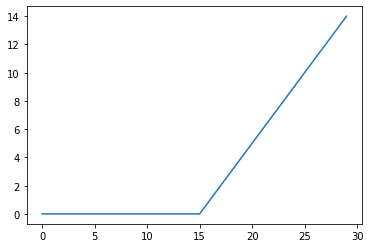

In [100]:
plt.plot(relu(raw_data))

## Now the model is ready...

### The model has the following structure

In [25]:
toamato_disease_detector_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (16, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model


In [46]:
toamato_disease_detector_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
             optimizer=tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

## Fitting the model

In [29]:
history = toamato_disease_detector_model.fit(train_data,
                   epochs = 5,
                   batch_size = BATCH_SIZE,
                   verbose = 1,
                   validation_data = validation_data)

Epoch 1/5
340/340 [==============================] - 2032s 6s/step - loss: 0.0358 - accuracy: 0.9875 - val_loss: 0.0414 - val_accuracy: 0.9836
Epoch 2/5
340/340 [==============================] - 2187s 6s/step - loss: 0.0347 - accuracy: 0.9899 - val_loss: 0.0166 - val_accuracy: 0.9940
Epoch 3/5
340/340 [==============================] - 2139s 6s/step - loss: 0.0353 - accuracy: 0.9880 - val_loss: 0.0139 - val_accuracy: 0.9970
Epoch 4/5
340/340 [==============================] - 1543s 5s/step - loss: 0.0293 - accuracy: 0.9892 - val_loss: 0.0068 - val_accuracy: 0.9970
Epoch 5/5
340/340 [==============================] - 1593s 5s/step - loss: 0.0469 - accuracy: 0.9849 - val_loss: 0.0514 - val_accuracy: 0.9851


In [32]:
model_version=1
toamato_disease_detector_model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


## Someone might ask...
* What on earth is going on? how this model achieves this much accuracy on the very first epoch?
* The answer is....of course as we can see from the above cell there are only five epochs...but I fitted the model for fifty epochs and got 99.6% accuracy and I forgot to save the model and I refitted the model for 5 epochs...

## Loading the saved model...

In [21]:
import tensorflow as tf
model = tf.keras.models.load_model("C:/Users/B2GWA/Documents/Python_Projects/Tomato_Disease_Detection/models/1/")
#saved_model.summary()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

## Visualizing the model's working using different techniques

#### Remember "Machine Learning Explorer's Motto!!!"...Visualize, Visualize, Visualize... 

In [51]:
model.evaluate(test_data)

44/44 [==============================] - 20s 454ms/step - loss: 0.0298 - accuracy: 0.9901


[0.02977747842669487, 0.9900568127632141]

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

## Time to make use of the Model
* I am going to define a custom function that will display few selected images while evaluating the model 

In [58]:
#The following function will take in the model and
#compare the actual class and the predicted class
#while dissplaying both labels at the same time

import numpy as np
def plot_predicted_actual_label(model, test_data_set):
    for image_data, labels_data in test_data_set.take(1):
        plt.figure(figsize=(15,15))
        for i in range(12):
            plt.subplot(3,4,i+1)
            target_image = image_data[i].numpy().astype('uint8')
            target_label = labels_data[i].numpy()
            
            #Displaying the first image and predict
            plt.imshow(target_image)
            plt.title(class_names[target_label])
            
            predicted_image = model.predict(image_data)
            plt.xlabel(class_names[np.argmax(predicted_image[i])])

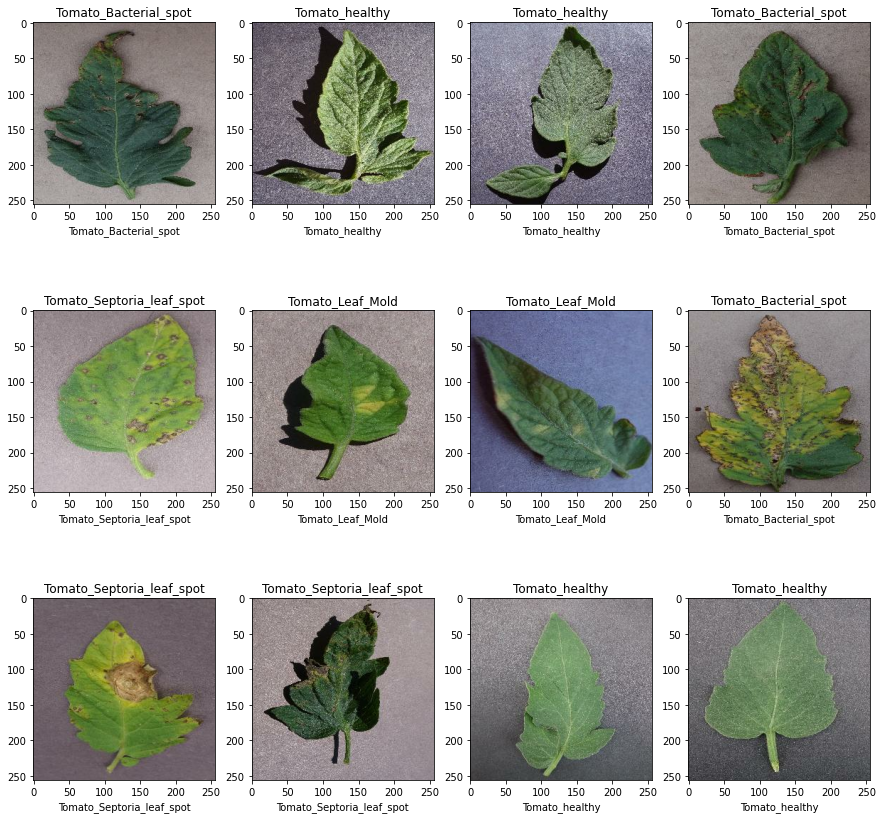

In [59]:
plot_predicted_actual_label(model, test_data)

* As we can we see from the above list of figures, the display looks as ugly as me...
* Now I will rewrite the function to display much better view along with prediction confidence of the model

In [63]:
def predict(model, img):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array,0)
    predictions = model.predict(image_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

* Before call the predict function, let's take alook at what `tf.keras.preprocessing.image.img_to_array(images[i].numpy())` does for us...

In [65]:
for images, labels in test_data.take(1):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     print(image_array)
#     plt.imshow(image_array.astype("uint8"))
image_array

array([[[175., 162., 172.],
        [ 85.,  72.,  82.],
        [139., 126., 136.],
        ...,
        [171., 160., 168.],
        [167., 156., 164.],
        [170., 159., 167.]],

       [[140., 127., 137.],
        [120., 107., 117.],
        [118., 105., 115.],
        ...,
        [173., 162., 170.],
        [162., 151., 159.],
        [160., 149., 157.]],

       [[133., 120., 130.],
        [134., 121., 131.],
        [133., 120., 130.],
        ...,
        [183., 172., 180.],
        [176., 165., 173.],
        [176., 165., 173.]],

       ...,

       [[113., 100., 109.],
        [106.,  93., 102.],
        [103.,  90.,  99.],
        ...,
        [104.,  91., 101.],
        [ 92.,  79.,  89.],
        [107.,  94., 104.]],

       [[102.,  89.,  98.],
        [ 95.,  82.,  91.],
        [ 83.,  70.,  79.],
        ...,
        [111.,  98., 108.],
        [114., 101., 111.],
        [117., 104., 114.]],

       [[ 90.,  77.,  86.],
        [106.,  93., 102.],
        [101.,  

In [67]:
image_array.shape

(256, 256, 3)

In [70]:
image_array=tf.expand_dims(image_array, 0)
image_array

<tf.Tensor: shape=(1, 1, 1, 256, 256, 3), dtype=float32, numpy=
array([[[[[[175., 162., 172.],
           [ 85.,  72.,  82.],
           [139., 126., 136.],
           ...,
           [171., 160., 168.],
           [167., 156., 164.],
           [170., 159., 167.]],

          [[140., 127., 137.],
           [120., 107., 117.],
           [118., 105., 115.],
           ...,
           [173., 162., 170.],
           [162., 151., 159.],
           [160., 149., 157.]],

          [[133., 120., 130.],
           [134., 121., 131.],
           [133., 120., 130.],
           ...,
           [183., 172., 180.],
           [176., 165., 173.],
           [176., 165., 173.]],

          ...,

          [[113., 100., 109.],
           [106.,  93., 102.],
           [103.,  90.,  99.],
           ...,
           [104.,  91., 101.],
           [ 92.,  79.,  89.],
           [107.,  94., 104.]],

          [[102.,  89.,  98.],
           [ 95.,  82.,  91.],
           [ 83.,  70.,  79.],
           

In [76]:
image_array.shape

(256, 256, 3)

* The following image data is in PIL format

In [75]:
for images, labels in test_data.take(1):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i])
#     print(image_array)
#     plt.imshow(image_array.astype("uint8"))
image_array

array([[[108.,  94., 107.],
        [113.,  99., 112.],
        [118., 104., 117.],
        ...,
        [140., 126., 139.],
        [123., 109., 122.],
        [138., 124., 137.]],

       [[117., 103., 116.],
        [113.,  99., 112.],
        [100.,  86.,  99.],
        ...,
        [128., 114., 127.],
        [150., 136., 149.],
        [179., 165., 178.]],

       [[135., 121., 134.],
        [142., 128., 141.],
        [133., 119., 132.],
        ...,
        [150., 136., 149.],
        [152., 138., 151.],
        [158., 144., 157.]],

       ...,

       [[156., 146., 157.],
        [139., 129., 140.],
        [148., 138., 149.],
        ...,
        [195., 187., 202.],
        [127., 119., 134.],
        [159., 151., 166.]],

       [[160., 150., 161.],
        [160., 150., 161.],
        [152., 142., 153.],
        ...,
        [165., 157., 172.],
        [172., 164., 179.],
        [136., 128., 143.]],

       [[147., 137., 148.],
        [160., 150., 161.],
        [168., 1

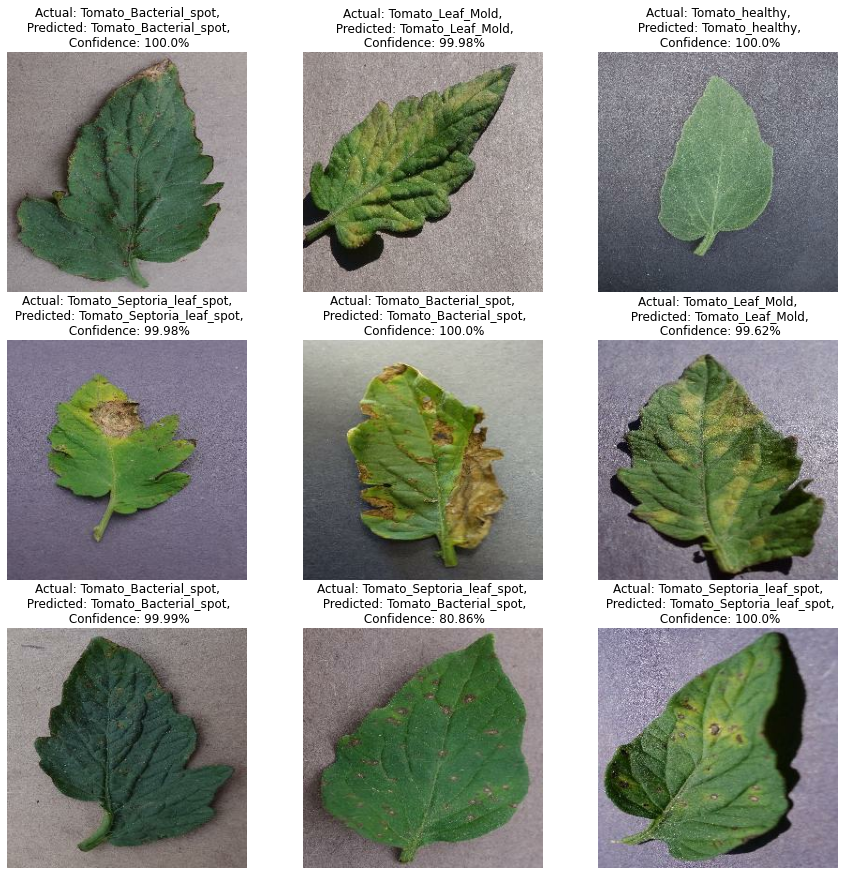

In [62]:
for images, labels in test_data.take(1):
    plt.figure(figsize = (15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

# What does the model look like?
* Well it looks like the following diagram

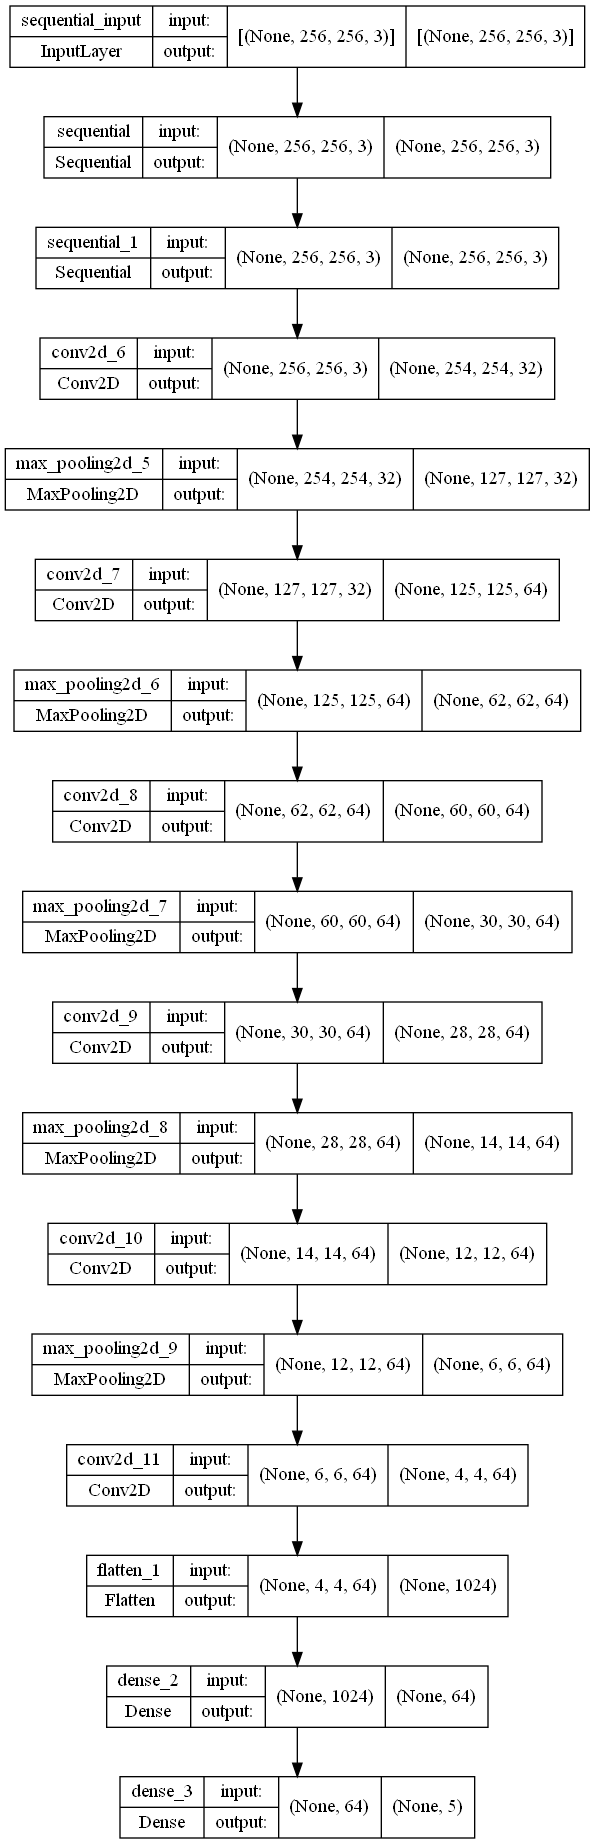

In [77]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)